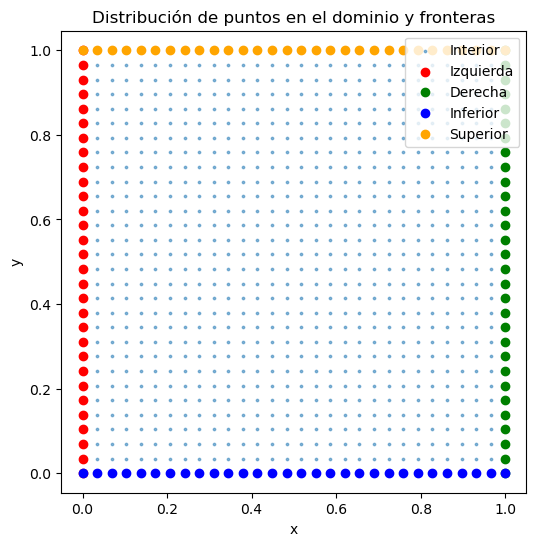

Epoch 0: Loss = 1.064e+00
Epoch 200: Loss = 6.493e-03
Epoch 400: Loss = 6.052e-03
Epoch 600: Loss = 5.936e-03
Epoch 800: Loss = 5.880e-03
Epoch 1000: Loss = 5.839e-03
Epoch 1200: Loss = 5.801e-03
Epoch 1400: Loss = 5.764e-03
Epoch 1600: Loss = 5.724e-03
Epoch 1800: Loss = 5.676e-03

Error L2 u_x: 6.227e-02
Error L2 u_y: 1.503e-01


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
# 1. Configuración del problema
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

E = 1.0
nu = 0.3
sigma0 = 1.0

# Constantes de Lamé
lam = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

# ==========================================================
# 2. Muestreo determinista (no aleatorio)
# ==========================================================
def sample_domain(nx, ny):
    x = torch.linspace(0, 1, nx)
    y = torch.linspace(0, 1, ny)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    xy = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
    xy.requires_grad_(True)
    return xy

def sample_boundary(n_per_side):
    # Izquierda (x=0)
    y = torch.linspace(0, 1, n_per_side)
    xb_left = torch.stack([torch.zeros_like(y), y], dim=1).to(device)

    # Derecha (x=1)
    xb_right = torch.stack([torch.ones_like(y), y], dim=1).to(device)

    # Inferior (y=0)
    x = torch.linspace(0, 1, n_per_side)
    xb_bottom = torch.stack([x, torch.zeros_like(x)], dim=1).to(device)

    # Superior (y=1)
    xb_top = torch.stack([x, torch.ones_like(x)], dim=1).to(device)

    for xb in [xb_left, xb_right, xb_bottom, xb_top]:
        xb.requires_grad_(True)

    return xb_left, xb_right, xb_bottom, xb_top

# ==========================================================
# 3. Visualización del muestreo
# ==========================================================
def plot_sampling(x_int, x_left, x_right, x_bottom, x_top):
    plt.figure(figsize=(6, 6))
    plt.scatter(x_int[:, 0].cpu().detach().numpy(), x_int[:, 1].cpu().detach().numpy(), s=3, label='Interior', alpha=0.5)
    plt.scatter(x_left[:, 0].cpu().detach().numpy(), x_left[:, 1].cpu().detach().numpy(), c='r', label='Izquierda')
    plt.scatter(x_right[:, 0].cpu().detach().numpy(), x_right[:, 1].cpu().detach().numpy(), c='g', label='Derecha')
    plt.scatter(x_bottom[:, 0].cpu().detach().numpy(), x_bottom[:, 1].cpu().detach().numpy(), c='b', label='Inferior')
    plt.scatter(x_top[:, 0].cpu().detach().numpy(), x_top[:, 1].cpu().detach().numpy(), c='orange', label='Superior')
    plt.legend()
    plt.title("Distribución de puntos en el dominio y fronteras")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

# ==========================================================
# 4. Red neuronal
# ==========================================================
class Net(nn.Module):
    def __init__(self, n_input=2, n_hidden=40, n_output=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        return self.net(x)

# ==========================================================
# 5. Gradientes
# ==========================================================
def gradients(u, x):
    return torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

# ==========================================================
# 6. Deformación y tensión
# ==========================================================
def strain_and_stress(u, x):
    ux, uy = u[:, 0:1], u[:, 1:2]
    grad_ux = gradients(ux, x)
    grad_uy = gradients(uy, x)

    exx = grad_ux[:, 0:1]
    eyy = grad_uy[:, 1:1+1]
    exy = 0.5 * (grad_ux[:, 1:1+1] + grad_uy[:, 0:1])

    div_u = exx + eyy

    sxx = lam * div_u + 2 * mu * exx
    syy = lam * div_u + 2 * mu * eyy
    sxy = 2 * mu * exy

    return exx, eyy, exy, sxx, syy, sxy

# ==========================================================
# 7. Función de pérdida
# ==========================================================
def loss_function(model, x_int, x_left, x_right, x_bottom, x_top):
    u = model(x_int)
    _, _, _, sxx, syy, sxy = strain_and_stress(u, x_int)

    dsxx_dx = gradients(sxx, x_int)[:, 0:1]
    dsxy_dy = gradients(sxy, x_int)[:, 1:1+1]
    dsyy_dy = gradients(syy, x_int)[:, 1:1+1]
    dsxy_dx = gradients(sxy, x_int)[:, 0:1]

    L1 = torch.mean((dsxx_dx + dsxy_dy) ** 2)
    L2 = torch.mean((dsxy_dx + dsyy_dy) ** 2)
    loss_pde = L1 + L2

    # Izquierda: u=0
    u_left = model(x_left)
    loss_bc_left = torch.mean(u_left ** 2)

    # Derecha: sigma_xx = sigma0, sigma_xy = 0
    u_right = model(x_right)
    _, _, _, sxx_r, _, sxy_r = strain_and_stress(u_right, x_right)
    loss_bc_right = torch.mean((sxx_r - sigma0)**2 + sxy_r**2)

    # Inferior y superior: sigma_yy = sigma_xy = 0
    u_bottom = model(x_bottom)
    u_top = model(x_top)
    _, _, _, _, syy_b, sxy_b = strain_and_stress(u_bottom, x_bottom)
    _, _, _, _, syy_t, sxy_t = strain_and_stress(u_top, x_top)
    loss_bc_topbottom = torch.mean(syy_b**2 + sxy_b**2 + syy_t**2 + sxy_t**2)

    return loss_pde + loss_bc_left + loss_bc_right + loss_bc_topbottom

# ==========================================================
# 8. Entrenamiento
# ==========================================================
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

x_int = sample_domain(30, 30)
x_left, x_right, x_bottom, x_top = sample_boundary(30)

# Visualización del muestreo antes del entrenamiento
plot_sampling(x_int, x_left, x_right, x_bottom, x_top)

for epoch in range(2000):
    optimizer.zero_grad()
    loss = loss_function(model, x_int, x_left, x_right, x_bottom, x_top)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.3e}")

# ==========================================================
# 9. Comparación analítica
# ==========================================================
x_test = torch.linspace(0, 1, 50)
y_test = torch.linspace(0, 1, 50)
X, Y = torch.meshgrid(x_test, y_test, indexing='ij')
xy = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)

u_pred = model(xy).detach().cpu().numpy()
u_x_pred = u_pred[:, 0].reshape(50, 50)
u_y_pred = u_pred[:, 1].reshape(50, 50)

u_x_true = (sigma0 / E) * X.numpy()
u_y_true = -(nu * sigma0 / E) * Y.numpy()

error_ux = np.sqrt(np.mean((u_x_pred - u_x_true)**2))
error_uy = np.sqrt(np.mean((u_y_pred - u_y_true)**2))
print(f"\nError L2 u_x: {error_ux:.3e}")
print(f"Error L2 u_y: {error_uy:.3e}")



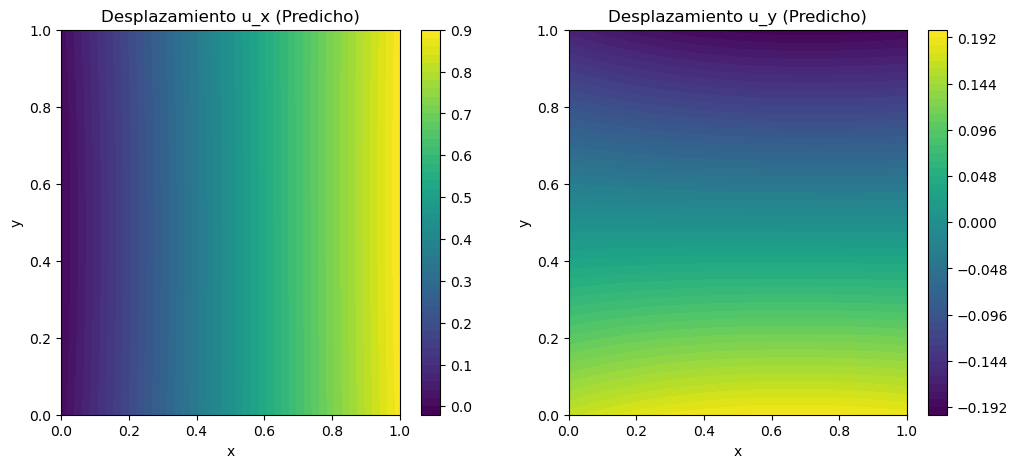

In [20]:
# ==========================================================
# 10. Visualización de resultados
# ==========================================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(X.numpy(), Y.numpy(), u_x_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.title("Desplazamiento u_x (Predicho)")
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
plt.contourf(X.numpy(), Y.numpy(), u_y_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.title("Desplazamiento u_y (Predicho)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
